<a id="top"></a>
# UN SDG Indicator 6.6.1:<br> Change in the Extent of Water-related Ecosystems


<hr>

# Notebook Summary
The United Nations have prescribed 17 "Sustainable Development Goals" (SDGs). This notebook attempts to monitor SDG Indicator 6.6.1 - change in the extent of water-related ecosystems. Indicator 6.6.1 has 4 sub-indicators:
>    i. The spatial extent of water-related ecosystems <br>
>    ii. The quantity of water contained within these ecosystems <br>
>    iii. The quality of water within these ecosystems <br>
>    iv. The health or state of these ecosystems <br>

This notebook primarily focuses on the first sub-indicator - spatial extents.

In the first section, one time period is analyzed. The mean of water classifications over time is visualized, the minimum and maximum water extents are visualized, and the frequency of water classification for each pixel is visualized.

In the second section, two time periods are analyzed - a baseline time period and an analysis time period. The change in pixels that are water at any time during their respective time periods is calculated, the change in water from the baseline time period to the analysis time period is visualized, and the area is classified by degree of change using classification labels provided by UN SDG 6.6.1.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Analyze a Single Time Period](#single_period)
    * [Define the Extents of the Analysis](#define_extents_single)
    * [Retrieve the Data from the Datacube](#retrieve_data_single)
    * [Get Water Classifications Using the WOFS Algorithm](#water_cls_single)
    * [Prepare for Visualization](#prepare_for_vis)
    * [Find the Minimum and Maximum Water Extents](#find_water_extents)
    * [Create Water Extent Image](#water_extent_image)
    * [Create a Time Series Plot of the Water](#time_series_water)
* [Compare Two Time Periods - a Baseline and an Analysis](#two_period)
    * [Define the Extents of the Analysis](#define_extents_baseline_analysis)
    * [Retrieve the Data from the Datacube](#retrieve_data_baseline_analysis)
    * [Get Water Classifications Using the WOFS Algorithm](#water_cls_baseline_analysis)
    * [Show and Analyze the Differences Between the Two Time Periods](#show_analyze_diff)
    * [Classify the Area by Degree of Change](#classify_by_degree_change)

## <a id="import"></a>Import Dependencies and Connect to the Data Cube [&#9652;](#top)

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt

# Allow importing of our utilities.
import sys
sys.path.append("..")

# Import the datacube and the API
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
import datetime as dt
import numpy as np
import xarray as xr
import pandas as pd

from matplotlib.colors import LinearSegmentedColormap

In [3]:
# Create an instance of the datacube and API.
api = DataAccessApi()
dc = api.dc

## <a id="plat_prod"></a>Choose Platforms and Products [&#9652;](#top)

**List available products for each platform**

In [4]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
2,LANDSAT_7,ls7_usgs_sr_scene


In [5]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
1,LANDSAT_8,ls8_usgs_sr_scene


**Choose products**

In [6]:
# These are the platforms (satelltes) and products (datacube sets) 
# used for this demonstration.
# Single time period analysis
platforms_single = ['LANDSAT_8']
products_single = ['ls8_usgs_sr_scene']
# Two time period analysis
platforms_two = ['LANDSAT_7', 'LANDSAT_8']
products_two = ['ls7_usgs_sr_scene', 'ls8_usgs_sr_scene']

all_platforms = []
for x in platforms_single + platforms_two:
    all_platforms.append(x) if x not in all_platforms else None
all_products = []
for x in products_single + products_two:
    all_products.append(x) if x not in all_products else None

## <a id="extents"></a>Get the Extents of the Cube [&#9652;](#top)

In [7]:
from utils.data_cube_utilities.dc_load import get_overlapping_area
from utils.data_cube_utilities.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = \
    get_overlapping_area(api, all_platforms, all_products)

# Print the extents of each product.
str_min_max_dates = np.vectorize(dt_to_str)(min_max_dates)
for i, (platform, product) in enumerate(zip(all_platforms, all_products)):
    print("For platform {} and product {}:".format(platform, product))
    print("Time Extents:", str_min_max_dates[i])
    print()

# Print the extents of the combined data.
min_start_date_mutual = np.max(min_max_dates[:,0])
max_end_date_mutual = np.min(min_max_dates[:,1])
print("Overlapping Extents:")
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, (min_start_date_mutual, max_end_date_mutual))))

For platform LANDSAT_8 and product ls8_usgs_sr_scene:
Time Extents: ['2013-03-21' '2020-01-27']

For platform LANDSAT_7 and product ls7_usgs_sr_scene:
Time Extents: ['1999-07-08' '2020-01-10']

Overlapping Extents:
Latitude Extents: (-12.57305555565614, 18.32305555570214)
Longitude Extents: (-25.47250000020378, 44.01000000035208)
Time Extents: ['2013-03-21', '2020-01-10']


**Visualize the full area**

In [8]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(full_lat, full_lon)

## <a id="single_period"></a>Analyze a Single Time Period  [&#9652;](#top)

### <a id="define_extents_single"></a>Define the Extents of the Analysis [&#9652;](#top)

**Specify start and end dates**

In [9]:
# Select a subset of the time available (year, month, day).
time_extents_single = [dt.datetime(2014,1,1), dt.datetime(2014,12,31)]

**Specify an area to analyze**

In [10]:
# Specify latitude and longitude bounds of an interesting area within the full extents.

# Ghana
# lat = (6.5016, 6.5221) # Lake Volta (very small)
# lon = (-0.1618, -0.100) # Lake Volta (very small)
# lat = (6.5016, 6.5821) # Lake Volta (small)
# lon = (-0.1618, -0.055) # Lake Volta (small)
# lat = (6.5138, 6.5292) # Lake Volta (medium)
# lon = (-0.1669, -0.1493) # Lake Volta (medium)
# lat = (6.2989, 7.9287) # Lake Volta (large)
# lon = (-0.4559, 0.2637) # Lake Volta (large)
lat =  (10.8600, 10.9350) # Tono Dam
lon = (-1.1934, -1.1423) # Tono Dam

# Lake Sulunga, Tanzania
# lat = (-6.3605, -5.8252) # Large 
# lon = (34.9756, 35.4535) # Large
# lat = (-6.2593, -5.8701) # Small (close fit)
# lon = (34.9901, 35.3641) #  Small (close fit)

# Lake Manyara, Tanzania
# lat = (-3.8505, -3.3886) 
# lon = (35.7184, 35.9271)

# Vietnam
# lat = (10.037934, 10.237934) 
# lon = (104.992264, 105.192264)
# lat = (11.0645, 11.2845) # Tri An Lake
# lon = (106.9567, 107.2967) # Tri An Lake

**Visualize the selected area**

In [11]:
display_map(lat, lon)

### <a id="retrieve_data_single"></a>Retrieve the Data from the Datacube [&#9652;](#top)

In [12]:
from utils.data_cube_utilities.dc_load import match_dim_sizes
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask, landsat_clean_mask_invalid
from utils.data_cube_utilities.aggregate import xr_scale_res
from utils.data_cube_utilities.sort import xarray_sortby_coord

def load_for_time_range(platforms, products, time_extents):
    measurements = ['red', 'blue', 'green', 'nir', 'swir1', 'swir2', 'pixel_qa']
    matching_abs_res, same_dim_sizes = match_dim_sizes(dc, products, lon, lat)
    datasets = {}
    clean_masks = {}
    for platform, product in zip(platforms, products):
        # Load the dataset.
        dataset = dc.load(platform=platform, product=product, lat=lat, lon=lon, 
                          time=time_extents, measurements=measurements,
                          group_by='solar_day', 
                          dask_chunks={'latitude':1000, 'longitude':1000, 'time':1}).persist()
        if len(dataset.dims) == 0: # The dataset is empty.
            continue
        # Get the clean mask.
        clean_mask = (landsat_qa_clean_mask(dataset, platform) &
                      ((dataset != -9999).to_array().all('variable')) &
                      landsat_clean_mask_invalid(dataset)).persist()
        dataset = dataset.drop('pixel_qa')
        # Discard acquisitions with no clean data.
        acq_times_to_keep = dataset.time.isel(time=(clean_mask.mean(['latitude', 'longitude']) > 0.001))
        dataset = dataset.sel(time=acq_times_to_keep)
        clean_mask = clean_mask.sel(time=acq_times_to_keep)
        # If needed, scale the datasets and clean masks to the same size in the x and y dimensions.
        if not same_dim_sizes:    
            dataset = xr_scale_res(dataset, abs_res=matching_abs_res)
            clean_mask = xr_scale_res(clean_mask.astype(np.uint8), abs_res=matching_abs_res).astype(np.bool)
        # Clean the data.
        dataset = dataset.astype(np.float16).where(clean_mask)
        datasets[product], clean_masks[product] = dataset, clean_mask
    # Combine everything.
    if len(datasets) > 0:
        dataset = xarray_sortby_coord(xr.concat(list(datasets.values()), dim='time'), coord='time')
        clean_mask = xarray_sortby_coord(xr.concat(list(clean_masks.values()), dim='time'), coord='time')
    else:
        dataset = xr.Dataset()
        clean_mask = xr.DataArray(np.empty((0,), dtype=np.bool))
    return dataset, clean_mask

In [13]:
dataset, clean_mask = load_for_time_range(platforms_single, products_single, time_extents_single)
dataset = dataset.persist()
clean_mask = clean_mask.persist()

### <a id="water_cls_single"></a> Get Water Classifications Using the WOFS Algorithm [&#9652;](#top)

In [14]:
# Whether or not to denoise the WOFS classifications.
denoise = False

# Denoising parameters may need to be tuned depending on the region and resolution scaling.
# *min_size*: Minimum size of connected pixels 
# that will not be filtered (minimum=2).
# *kernel_size*: Diameter of the modal kernal (minimum=3). 
# Larger values will run slower as it calculates the mode 
# of the neighborhood for each pixel inside this diameter.
# *connectivity*: Maximum distance between any two pixels. 
# A value of 1 allows only contiguous regions of pixels.
# *max_num_filter_runs*: The filter is run until the output stops changing 
# or this number of runs has been performed. 
std_denoise_params = dict(min_size=40, kernel_size=7, connectivity=10)
max_num_filter_runs = 4

In [15]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
from utils.data_cube_utilities.dc_utilities import ignore_warnings
from utils.data_cube_utilities.raster_filter import lone_object_filter

def get_water_classifications(dataset, clean_mask, max_num_filter_runs, 
                              denoise=False, denoise_params=None):
    # Get WOFS classifications.
    water_da = ignore_warnings(wofs_classify, dataset).wofs
    water_da = water_da.where(clean_mask)

    # Denoise the classifications.
    if denoise:
        denoise_params = std_denoise_params if denoise_params is None else denoise_params
        
        # Encode NaN as -1 for `lone_object_filter()`.
        water_da = water_da.where(~xr_nan(water_da), -1)
        for time in water_da.time:
            water_slice_prev = water_da.sel(time=time).values
            water_slice_new = lone_object_filter(water_slice_prev, **std_denoise_params)
            # While the filter output is still changing or until the filter has
            # been run `max_num_filter_runs` times, keep rerunning it.
            filter_run_count = 0
            while (water_slice_new != water_slice_prev).any() and \
                  filter_run_count < max_num_filter_runs:
                water_slice_prev = water_slice_new
                water_slice_new = lone_object_filter(water_slice_prev, **std_denoise_params)
                filter_run_count += 1
            water_da.sel(time=time).values[:] = water_slice_new
        water_da = water_da.where(water_da!=-1) # Reencode -1 as NaN.  
    return water_da

water_da = get_water_classifications(dataset, clean_mask, max_num_filter_runs,
                                     denoise, std_denoise_params)

In [16]:
# Resample the data in time to avoid cluttering the x axes of plots 
# with tick labels (dates) and also smooth the plots.
dataset = dataset.resample(time='2d').mean('time').dropna('time', how='all').persist()
clean_mask = (clean_mask.resample(time='2d').mean('time').dropna('time', how='all') >= 0.5).persist()
water_da = water_da.resample(time='2d').mean('time').dropna('time', how='all').persist()

### <a id="prepare_for_vis"></a> Prepare for Visualization [&#9652;](#top)

In [17]:
# Define a standard dpi partly to tune font sizes in figures.
# A higher dpi and a lower figure size will result in larger 
# font sizes relative to the figure size.
std_dpi = 100

### <a id="find_water_extents"></a>**Find the Minimum and Maximum Water Extents** [&#9652;](#top)

**We are finding the minimum and maximum water extents based on a max-composite of water data. We do this to reduce the appearance of missing data due to cloud cover and to avoid cluttering a plot of the mean of water over time later.**

In [18]:
## Settings ##

# Formatting for full-width plots.
title_fontdict = dict(fontsize=16) # Title formatting
tick_label_fmt_dict = dict(axis='both', labelsize=12) # Tick label formatting
axis_label_fmt_dict = dict(fontsize=16) # Axis label formatting
legend_kwargs = dict(fontsize=12)

# Can be any of ['time-slice', 'per-pixel'].
# The value 'time-slice' obtains the minimum and maximum water extents on an time-slice basis.
# The value 'per-pixel' obtains the minumum and maximum water extents on a per-pixel basis.
water_extent_method = 'time-slice'
assert water_extent_method in ['time-slice', 'per-pixel'], \
    "The setting `water_extent_method` must be one of ['time-slice', 'per-pixel']."

# This setting is only relevant if `water_extent_method` is set to 'time-slice'.
# Water classifiers can sometimes output erroneous classifications and sometimes excessive clouds
# make compositing an impractical solution to accounting for noisy classifications. 
# And SAR data is sometimes unavailable for WASARD water classification over cloudy regions,
# so percentiles can be specified for the minimum and maximum time slices. These can be between
# 0 and 100. The minimum water time-slice selected will be the time slice with non-water extents
# at or below `percentile_min`. The maximum water time-slice selected will be the time slice 
# with water extents at or below `percentile_max`.
percentile_min, percentile_max = 100, 100

## End Settings ##

# Option 1: Obtain the acquisitions with the minimum and maximum water extents.
if water_extent_method == 'time-slice':
    count_non_water = water_da.where(water_da == 0).count(dim=['latitude', 'longitude'])
    count_water = water_da.where(water_da == 1).count(dim=['latitude', 'longitude'])
    
    # Find the acquisition with the least water (the one with the most non-water pixels).
    percentile_value_min = np.percentile(count_non_water, percentile_min, interpolation='lower')
    # Handle the case of multiple acquisitions with the same amount of non-water (notably 0).
    acqs_with_value_min = count_non_water == percentile_value_min
    if acqs_with_value_min.sum() > 1: # Find the acquisition with the least water (and most non-water).
        min_extent_time_ind = np.argmin(count_water.isel(time=acqs_with_value_min).values)
    else:
        min_extent_time_ind = (count_non_water == percentile_value_min).argmax().values
    min_extent_time = water_da.time.values[min_extent_time_ind]
    min_water_extent = water_da.isel(time=min_extent_time_ind)

    # Find the acquisition with the most water (the one with the most water pixels).
    percentile_value_max = np.percentile(count_water, percentile_max, interpolation='lower')
    # Handle the case of multiple acquisitions with the same amount of water (notably 0).
    acqs_with_value_max = count_water == percentile_value_max
    if acqs_with_value_max.sum() > 1: # Find the acquisition with the least non-water (and most water).
        max_extent_time_ind = np.argmin(count_non_water.isel(time=acqs_with_value_max).values)
    else:
        max_extent_time_ind = (count_water == percentile_value_max).argmax().values
    max_extent_time = water_da.time.values[max_extent_time_ind]
    max_water_extent = water_da.isel(time=max_extent_time_ind)
    
    dt64_to_date_str = lambda dt64 : pd.to_datetime(str(dt64)).strftime('%Y/%m/%d')
    max_water_date_str = dt64_to_date_str(max_extent_time)
    min_water_date_str = dt64_to_date_str(min_extent_time)
    
# Option 2: Obtain the minimum and maximum water extents on a per-pixel basis.
else: 
    min_water_extent = water_da.min('time')
    max_water_extent = water_da.max('time')
    max_water_date_str = "N/A"
    min_water_date_str = "N/A"

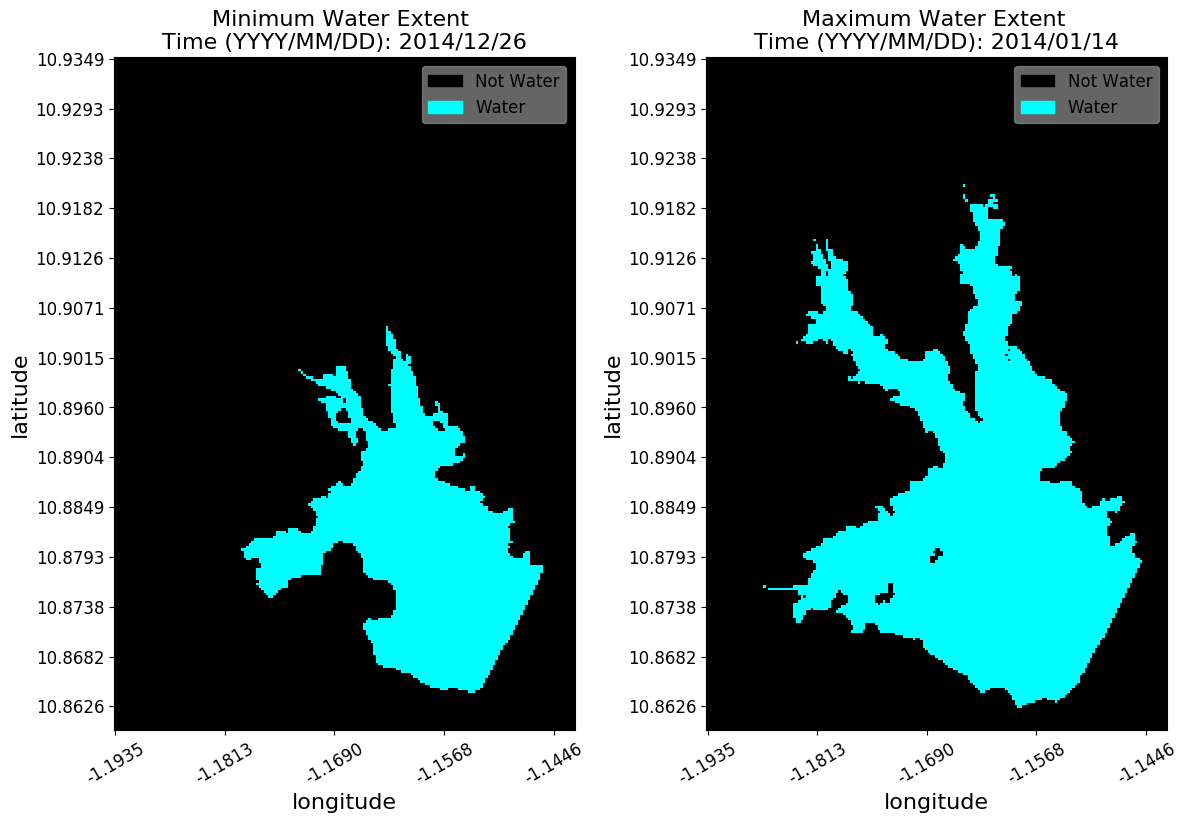

In [19]:
from utils.data_cube_utilities.plotter_utils import create_discrete_color_map, xarray_imshow
from utils.data_cube_utilities.plotter_utils import figure_ratio

# Begin plotting the data
fig_width = 12 # Use this to change the size of this figure.
fig = plt.figure(figsize=figure_ratio(water_da, fixed_width=fig_width), dpi=std_dpi)

# Create common colormap.
cmap = create_discrete_color_map([0,1], ['black', 'cyan'])

imshow_kwargs = dict(vmin=0, vmax=1, cmap=cmap)

legend_labels = {0:'Not Water', 1:'Water'}

# Minimum water extent
ax = plt.subplot(1,2,1)
fig, ax, im, cbar = \
    xarray_imshow(min_water_extent, fig=fig, ax=ax, use_colorbar=False, use_legend=True, 
                  legend_labels=legend_labels, imshow_kwargs=imshow_kwargs, 
                  x_label_kwargs=axis_label_fmt_dict, y_label_kwargs=axis_label_fmt_dict,
                  legend_kwargs=legend_kwargs)
ax.set_title("Minimum Water Extent \nTime (YYYY/MM/DD): {}".format(min_water_date_str), fontdict=title_fontdict)
ax.tick_params(**tick_label_fmt_dict)

# Maximum water extent
ax = plt.subplot(1,2,2)
fig, ax, im, cbar = \
    xarray_imshow(max_water_extent, fig=fig, ax=ax, use_colorbar=False, use_legend=True, 
                  legend_labels=legend_labels, imshow_kwargs=imshow_kwargs,
                  x_label_kwargs=axis_label_fmt_dict, y_label_kwargs=axis_label_fmt_dict,
                  legend_kwargs=legend_kwargs)
ax.set_title("Maximum Water Extent \nTime (YYYY/MM/DD): {}".format(max_water_date_str), fontdict=title_fontdict)
ax.tick_params(**tick_label_fmt_dict)

plt.tight_layout()
plt.show()

### <a id="water_extent_image"></a>**Create Water Extent Image** [&#9652;](#top)

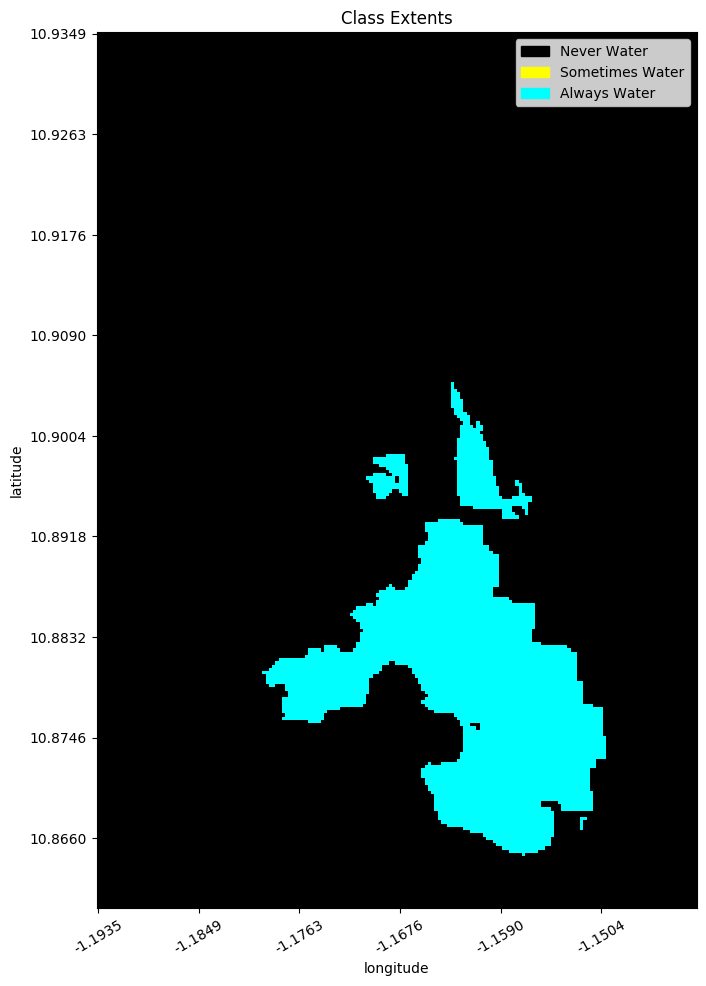

In [20]:
from utils.data_cube_utilities.plotter_utils import binary_class_change_plot

fig_width = 6 # Use this to change the size of this figure.
fig = plt.figure(figsize=figure_ratio(water_da, fixed_width=fig_width), dpi=std_dpi)

# Shade 3 regions - never, sometimes, and always water.
(fig,ax), [never_sometimes_always_stats] = \
    binary_class_change_plot(
        [water_da==1], [clean_mask], colors=['black', 'yellow', 'cyan'], 
        class_legend_label='Water', fig=fig)
plt.show()

In [21]:
index = list(map(lambda str: str.format('Water'),
                  ['Never {}', 'Sometimes {}', 'Always {}', 
                   'Max {}', 'Min {}', 'No Data']))

num_table_rows = len(index)

stats_table_single = pd.DataFrame(data=np.zeros((num_table_rows, 4)),
                                  index=index, columns=['Date (YYYY/MM/DD)', 'Number', 'Percent', 'Area (km^2)'])

## Date
# There are the dates for the rows.
dates = np.array(['', '', '', max_water_date_str, min_water_date_str, ''])
stats_table_single.loc[:,'Date (YYYY/MM/DD)'] = dates

## Number
class_sums = np.array([never_sometimes_always_stats.loc['Never Water'].Number, 
                       never_sometimes_always_stats.loc['Sometimes Water'].Number,
                       never_sometimes_always_stats.loc['Always Water'].Number, 
                       max_water_extent.sum().values, 
                       min_water_extent.sum().values, 
                       never_sometimes_always_stats.loc['Unknown'].Number])
stats_table_single.loc[:, 'Number'] = class_sums

## Area
# Show pixel changes and calculate area using pixel resolution
prod_info = dc.list_products()
deg_per_px = prod_info[prod_info['name'] == products_single[0]]['resolution'].values[0]
deg_per_px = np.abs(deg_per_px)
# Roughly 111km per degree of latitude and longitude.
km_per_px = 111 * deg_per_px
# Calculate the total area.
sq_km_per_px = np.prod(km_per_px)
stats_table_single.loc[:, 'Area (km^2)'] = stats_table_single.loc[:,'Number'] * sq_km_per_px

## Percent
stats_table_single.loc[:, 'Percent'] = \
    [never_sometimes_always_stats.loc['Never Water'].Percent, 
     never_sometimes_always_stats.loc['Sometimes Water'].Percent,
     never_sometimes_always_stats.loc['Always Water'].Percent, 
     max_water_extent.mean().values, 
     min_water_extent.mean().values, 
     never_sometimes_always_stats.loc['Unknown'].Percent]
stats_table_single_fmt = stats_table_single.copy()
stats_table_single_fmt.loc[:, 'Percent'] = [f"{pct:0.2%}" for pct in stats_table_single.loc[:, 'Percent']]
stats_table_single_fmt

,Date (YYYY/MM/DD),Number,Percent,Area (km^2)
Never Water,,37343.0,74.76%,35.501783
Sometimes Water,,7359.0,14.73%,6.996160
Always Water,,5248.0,10.51%,4.989244
Max Water,2014/01/14,12554.0,25.13%,11.935018
Min Water,2014/12/26,6930.0,13.87%,6.588313
No Data,,0.0,0.00%,0.000000


### <a id="time_series_water"></a>Create a Time Series Plot of the Water [&#9652;](#top)

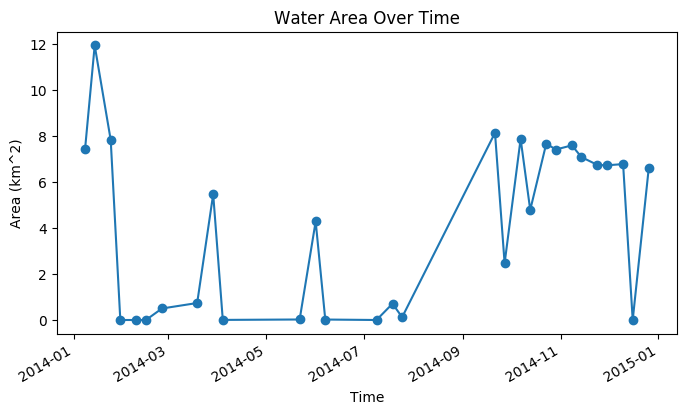

In [22]:
from utils.data_cube_utilities.plotter_utils import xarray_time_series_plot
from utils.data_cube_utilities.plotter_utils import np_dt64_to_str

total_area = len(water_da.latitude) * len(water_da.longitude) * sq_km_per_px

figsize = (8, 4) # The width and height of the figure, respectively.
fig = plt.figure(figsize=figsize, dpi=std_dpi)

(water_da.sum(['latitude', 'longitude']) * sq_km_per_px).plot.line(marker='o')
plt.title('Water Area Over Time')
plt.ylabel('Area (km^2)')
plt.xlabel('Time')
plt.show()

## <a id="two_period"></a>Compare Two Time Periods - a Baseline and an Analysis [&#9652;](#top)

### <a id="define_extents_baseline_analysis"></a>Define the Extents of the Analysis [&#9652;](#top)

**Specify start and end dates**

In [23]:
# Select a subset of the time available.
time_extents_two = {'baseline': [dt.datetime(2002,1,1), dt.datetime(2002,12,31)],
                    'analysis': [dt.datetime(2014,1,1), dt.datetime(2014,12,31)]}

**Visualize the selected area**

In [24]:
display_map(lat, lon)

### <a id="retrieve_data_baseline_analysis"></a>Retrieve the Data from the Datacube [&#9652;](#top)

In [25]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic

datasets = {} # Maps categories to cleaned datasets.
clean_masks = {} # Maps categories to clean masks.
datasets_median_composites = {}
for category, time_extents in list(time_extents_two.items()):
    # Use LANDSAT_7 for the baseline because its SLC was broken afterward (2003).
    if category == 'baseline':
        platform = platforms_two[0]
        product = products_two[0]
    else: 
        platform = platforms_two[1]
        product = products_two[1]
    datasets[category], clean_masks[category] = \
        load_for_time_range([platform], [product], time_extents)
    datasets[category] = datasets[category].persist()
    clean_masks[category] = clean_masks[category].persist()
    datasets_median_composites[category] = \
        create_median_mosaic(datasets[category], clean_masks[category]).persist()

### <a id="water_cls_baseline_analysis"></a>Get Water Classifications Using the WOFS Algorithm [&#9652;](#top)

In [26]:
# Get WOFS classifications.
water_das = {}
for category in datasets:
    water_da = \
        get_water_classifications(datasets[category], clean_masks[category], 
                                  max_num_filter_runs, 
                                  denoise, std_denoise_params)
    water_das[category] = water_da

In [27]:
# Resample the data in time to avoid cluttering the x axes of plots 
# with tick labels (dates) and also smooth the plots.
for category in datasets:
    datasets[category] = datasets[category].resample(time='2d').mean('time').dropna('time', how='all').persist()
    clean_masks[category] = (clean_masks[category].resample(time='2d').mean('time').dropna('time', how='all') >= 0.5).persist()
    water_das[category] = water_das[category].resample(time='2d').mean('time').dropna('time', how='all').persist()

### <a id="show_water_extents"></a>**Show Water Extents of the Baseline and Analysis Periods** [&#9652;](#top)

**Show the median composite for each period.**
<br>The results are displayed using a false color RGB where water is dark blue

In [28]:
from utils.data_cube_utilities.plotter_utils import figure_ratio

## Settings ##

# Formatting for full-width plots.
title_fontdict = dict(fontsize=16) # Title formatting
tick_label_fmt_dict = dict(axis='both', labelsize=12) # Tick label formatting
axis_label_fmt_dict = dict(fontsize=16) # Axis label formatting
legend_kwargs = dict(fontsize=12)
std_dpi = 200 # Standard image dpi.

def std_figsize(fig_width): 
    return figure_ratio(datasets['baseline'].isel(time=0), fixed_width=fig_width)

# This is the name of the band used as the 
# graysale background when showing water extents.
background_band = 'swir1'

## End Settings ##

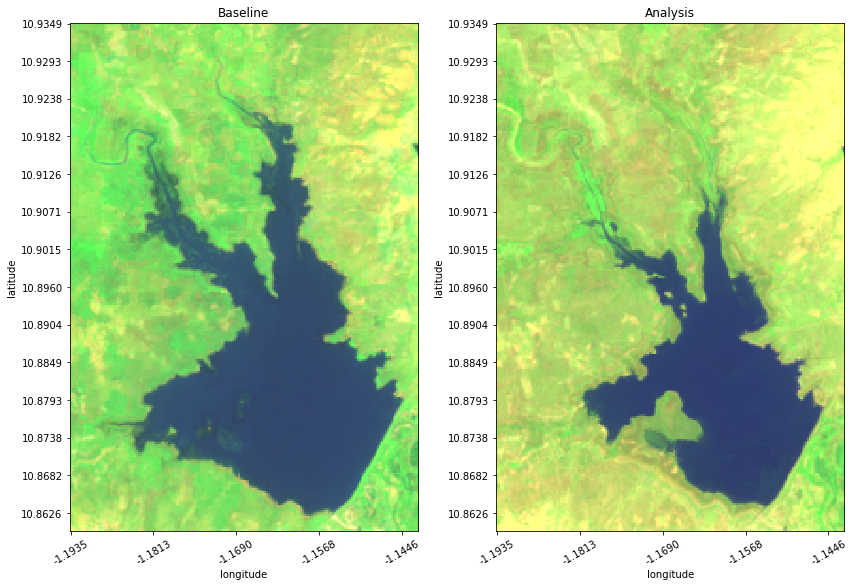

In [29]:
from utils.data_cube_utilities.dc_rgb import rgb

fig_width = 12 # Use this to change the size of this figure.
fig, ax = plt.subplots(1, 2, figsize=std_figsize(fig_width))

for i, category in enumerate(water_das):
    rgb(datasets_median_composites[category], fig=fig, ax=ax[i], 
        bands=['swir2', 'nir', 'green'], min_possible=0, max_possible=3000)
    ax[i].set_title(category.capitalize())
plt.tight_layout()
plt.show()

**Show which pixels are sometime water or always water for each period, with a gray-scale background.**
<br>Warning: These results can be impacted by cloud contamination. The identification of clouds in Landsat <br>scenes is not perfect, so errors in cloud identification can impact time series results

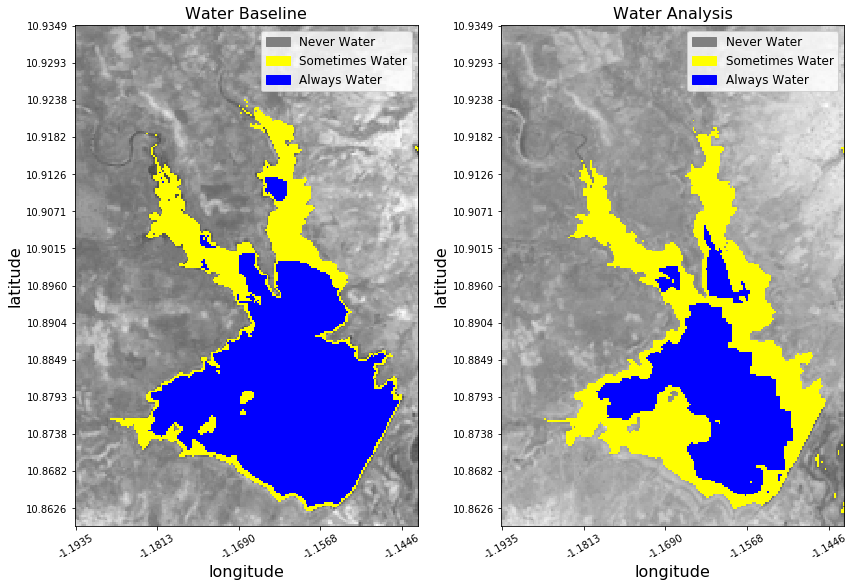

In [30]:
from utils.data_cube_utilities.plotter_utils import binary_class_change_plot

fig_width = 12 # Use this to change the size of this figure.
fig, ax = plt.subplots(1, 2, figsize=std_figsize(fig_width))

# Collect stats tables for each period so we can later create a change matrix.
stats_tables = {}

for i, category in enumerate(water_das):
    # Show water in blue over a grey-scale background.
    rgb(datasets_median_composites[category], bands=[background_band]*3, 
        ax=ax[i], use_data_min=True, use_data_max=True)
    water_composite = water_das[category].where(clean_masks[category], 0).mean('time')
    [fig, ax[i]], [stats_tables[category]] = \
    binary_class_change_plot(
        [water_das[category]==1],
        [clean_masks[category]],
        colors=['gray', 'yellow', 'blue'], 
        neg_trans=True,
        class_legend_label='Water', fig=fig, ax=ax[i], 
        title_kwargs=dict(label='Water ' + category.capitalize(), fontdict=title_fontdict),
        x_label_kwargs=axis_label_fmt_dict, y_label_kwargs=axis_label_fmt_dict, 
        legend_kwargs=legend_kwargs, 
        denoise=denoise, denoise_params=std_denoise_params)
plt.tight_layout()
plt.show()

### <a id="show_analyze_diff"></a>**Show and Analyze the Differences Between the Two Time Periods** [&#9652;](#top)

Compare the water extents of the cloud-filtered mosaics of the baseline and analysis time periods

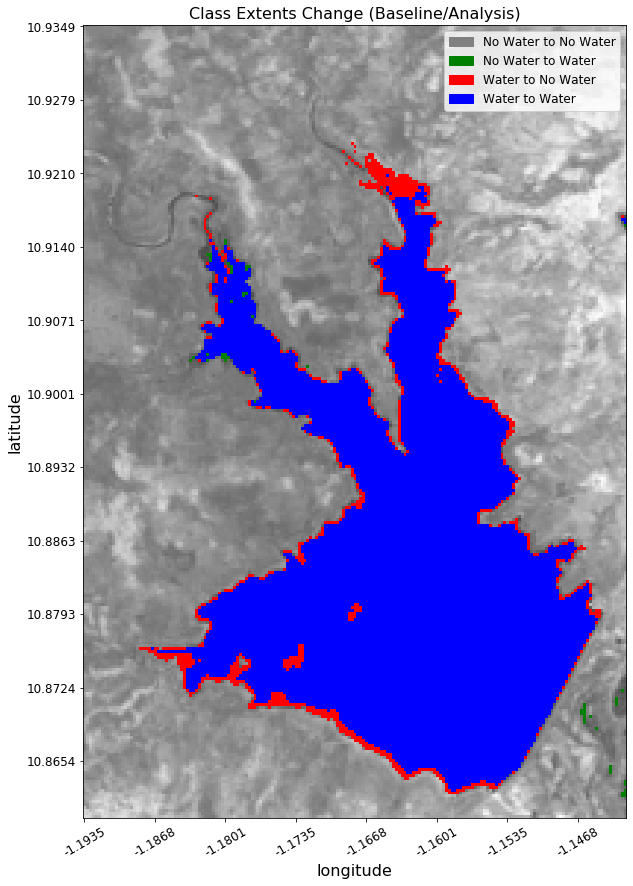

In [31]:
fig_width = 10 # Use this to change the size of this figure.
fig, ax = plt.subplots(figsize=std_figsize(fig_width))

# Show water change over a grey-scale background.
rgb(datasets_median_composites['baseline'], bands=[background_band]*3, 
    ax=ax, use_data_min=True, use_data_max=True)
# Show regions based on changes between having zero or more than zero times 
# in which they are classified as water between the two time periods.
[fig, ax], [stats_table_two, change_matrix] = \
    binary_class_change_plot(
        [water_das['baseline']==1, water_das['analysis']==1],
        [clean_masks['baseline'], clean_masks['analysis']],
        colors=['gray', 'green', 'red', 'blue'], 
        neg_trans=True,
        class_legend_label='Water', fig=fig, ax=ax, title_kwargs=dict(fontdict=title_fontdict),
        x_label_kwargs=axis_label_fmt_dict, y_label_kwargs=axis_label_fmt_dict, 
        legend_kwargs=legend_kwargs, 
        denoise=denoise, denoise_params=std_denoise_params)
ax.tick_params(**tick_label_fmt_dict)
plt.show()

**Change Statistics**

In [32]:
# Add area to the stats table.
# 1. Get resolution. In this case, we know the x and y coordinates are longitude and latitude
#    and that the products all have the same resolution.
prod_info = dc.list_products()
deg_per_px = prod_info[prod_info['name'] == all_products[0]]['resolution'].values[0]
deg_per_px = np.abs(deg_per_px)
# Roughly 111km per degree of latitude and longitude.
km_per_px = 111 * deg_per_px
# 2. Calculate the total area
length_in_km = km_per_px * np.array([len(water_das['baseline'].latitude),
                                         len(water_das['baseline'].longitude)])
total_area_in_km = np.prod(length_in_km)
# 3. Compute the area for each row of the stats table and display the table.
stats_table_two.loc[:, 'Area (km^2)'] = stats_table_two.loc[:,'Percent'] * total_area_in_km

# Format percent as strings.
stats_table_two_fmt = stats_table_two.copy()
stats_table_two_fmt.loc[:, 'Percent'] = [f"{pct:0.2%}" for pct in stats_table_two.loc[:, 'Percent']]
stats_table_two_fmt.loc[:, 'Area (km^2)'] = [f"{area:.3f}" for area in stats_table_two.loc[:, 'Area (km^2)']]
stats_table_two_fmt

,Number,Percent,Area (km^2)
No Water to No Water,36258,72.59%,34.470
No Water to Water,56,0.11%,0.053
Water to No Water,1085,2.17%,1.032
Water to Water,12551,25.13%,11.932
Net Change,1141,2.28%,1.085
Unknown,0,0.00%,0.000


**Change Matrix**

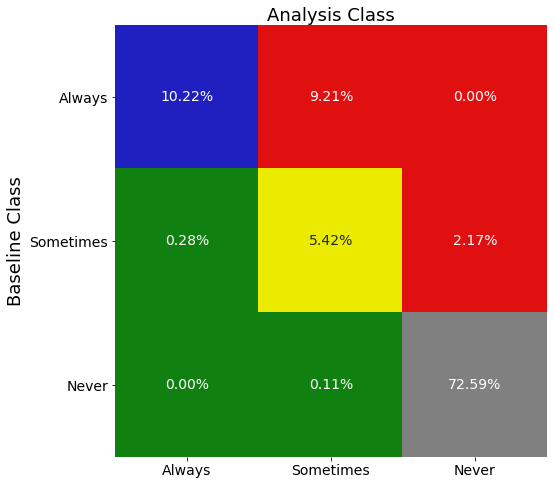

In [33]:
from utils.data_cube_utilities.dc_utilities import reverse_array_dict
from utils.data_cube_utilities.plotter_utils import create_discrete_color_map
from utils.data_cube_utilities.plotter_utils import print_matrix

# Create a colormap for coloring the cells in the change matrix.
# The colors are, in order, gray, red, green, yellow, and blue. Many are manually specified
# as rgb lists because their matplotlib named colors are fairly bright and saturated.
change_matrix_cmap = \
    create_discrete_color_map([0,4], colors=['gray', [225,16,16], [16,128,16], [235,235,0], [32,32,192]])

# This is a matrix specifying each class transition based on the color it should recieve.
# Original classes are indexed by row and final classes are indexed by column.
cng_vals = [0, 1, 2, 3, 4]
cng_mat = np.array([
    # Always Sometimes Never
    [     4,      1,      1], # Always
    [     2,      3,      1], # Sometimes 
    [     2,      2,      0], # Never   
])

# Create mappings of transitions to values for coloring based on a colormap.
cls_trans_for_value = {cng_val:[] for cng_val in cng_vals}
for i, orig_class in enumerate(change_matrix.baseline.values):
    for j, final_class in enumerate(change_matrix.analysis.values):
        cng_val = cng_mat[i,j]
        cls_trans_for_value[cng_val].append((orig_class, final_class))
value_for_cls_trans = reverse_array_dict(cls_trans_for_value)

# Create the cell value matrix (used to color cells).
cell_value_mtx = np.empty_like(change_matrix.Percent.values)
for i, cls_label1 in enumerate(change_matrix.baseline.values):
    for j, cls_label2 in enumerate(change_matrix.analysis.values):
        cell_value_mtx[i,j] = value_for_cls_trans[(cls_label1, cls_label2)]

cell_label_mtx = np.full_like(cell_value_mtx, '', dtype=object)
for i, baseline_category in enumerate(change_matrix['baseline']):
    for j, analysis_category in enumerate(change_matrix['analysis']):
        cell_label_mtx[i,j] = "{0:.2%}".format(change_matrix.Percent.values[i,j])

row_labels = [label.capitalize() for label in change_matrix.baseline.values]
col_labels = [label.capitalize() for label in change_matrix.analysis.values]

fig = plt.figure(figsize=(6,6))
fig, ax = print_matrix(cell_value_mtx, cell_val_fmt='s',
                       cell_label_mtx=cell_label_mtx, cmap=change_matrix_cmap,
                       row_labels=row_labels, col_labels=col_labels, 
                       x_axis_ticks_position='top', x_axis_tick_kwargs={},
                       annot_kwargs=dict(size=14), fig=fig)
ax.yaxis.set_label_position('left')
plt.ylabel('Baseline Class', fontsize=18)
ax.xaxis.set_label_position('top')
plt.xlabel('Analysis Class', fontsize=18)
plt.show()

**Calculate the area of each of the 9 transition classes in the change matrix.**

In [34]:
# 1. Get resolution. In this case, we know the x and y coordinates are longitude and latitude
#    and that the products all have the same resolution.
prod_info = dc.list_products()
deg_per_px = prod_info[prod_info['name'] == all_products[0]]['resolution'].values[0]
deg_per_px = np.abs(deg_per_px)
# Roughly 111km per degree of latitude and longitude.
meters_per_px = 111000 * deg_per_px

change_matrix['Area (m^2)'] = change_matrix.Number * np.prod(meters_per_px)
cng_mtx_as_table = change_matrix.to_dataframe().reset_index()
baseline_analysis_cls_strs = cng_mtx_as_table[['baseline', 'analysis']].values
cng_mtx_as_table.drop(columns=['analysis', 'baseline'], inplace=True)
cng_mtx_as_table.index = ["{} to {}".format(base_cls, analysis_cls) for base_cls, analysis_cls 
                            in baseline_analysis_cls_strs]
cng_mtx_as_table.style.format({'percent': "{:.2%}"})

,Number,Percent,Area (m^2)
always to always,5107,0.102242,4855196.527855
sometimes to always,141,0.002823,134047.916669
never to always,0,0.000000,0.000000
always to sometimes,4598,0.092052,4371293.055625
sometimes to sometimes,2705,0.054154,2571628.472263
never to sometimes,56,0.001121,53238.888890
always to never,0,0.000000,0.000000
sometimes to never,1085,0.021722,1031503.472239
never to never,36258,0.725886,34470279.167218


### <a id="classify_by_degree_change"></a>**Classify the Area by Degree of Change** [&#9652;](#top)

In [35]:
# Calculate the net change of water from the baseline to the analysis time periods.
starting_water_num = stats_table_two.loc[['Water to No Water', 'Water to Water'], ['Number']].sum()[0]
net_change_water_num = (stats_table_two.loc['No Water to Water', 'Number'] - \
                        stats_table_two.loc['Water to No Water', 'Number'])
net_change_water_pct = net_change_water_num / starting_water_num
print("The percent of change in the water extent from the baseline time period " \
      "to the analysis time period (relative change from the baseline) "\
      "is {0:.2%}.\n".format(net_change_water_pct))

# Classify the area by degree of change.
# Transitions from never water to some/always water (and vice versa) are considered changes.
frac_change_cls = stats_table_two.loc[['No Water to Water', 'Water to No Water'], ['Percent']].sum()[0]

region_class = None
frac_change_cls = abs(frac_change_cls)
if frac_change_cls <= 0.1:
    region_class = "Unmodified Natural (class A)"
if 0.1 < frac_change_cls <= 0.2:
    region_class = "Largely Natural (class B)"
if 0.2 < frac_change_cls <= 0.4:
    region_class = "Moderately Modified (class C)"
if 0.4 < frac_change_cls <= 0.6:
    region_class = "Largely Modified (class D)"
if 0.6 < frac_change_cls:
    region_class = "Seriously Modified (class E)"
print("The percent of pixels that are different water classes between the baseline and analysis time periods " \
      "is {0:.2%}, so this region can be classified as {1}".format(frac_change_cls, region_class))

The percent of change in the water extent from the baseline time period to the analysis time period (relative change from the baseline) is -7.55%.

The percent of pixels that are different water classes between the baseline and analysis time periods is 2.28%, so this region can be classified as Unmodified Natural (class A)
